In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import time
from tqdm.notebook import tqdm

# Global Variables

In [15]:
trainDF = pd.read_csv("HSV_LBPs_train.csv")
train_images = trainDF.iloc[:,:-1].copy().values
train_labels = trainDF.iloc[:,-1].copy().values

testDF = pd.read_csv("HSV_LBPs_test.csv")
test_images = testDF.iloc[:,:-1].copy().values
test_labels = testDF.iloc[:,-1].copy().values

valDF = pd.read_csv("HSV_LBPs_val.csv")
val_images = valDF.iloc[:,:-1].copy().values
val_labels = valDF.iloc[:,-1].copy().values

In [25]:
class MLP():
    
    def __init__(self,X,Y,X_val,Y_val,L=1,N_l=128):
        self.X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.Y = np.squeeze(np.eye(50)[Y.astype(np.int).reshape(-1)])
        self.X_val = np.concatenate((X_val,np.ones((X_val.shape[0],1))),axis=1)
        self.Y_val = np.squeeze(np.eye(50)[Y_val.astype(np.int).reshape(-1)])
        self.L = L
        self.N_l = N_l
        self.n_samples = self.X.shape[0]
        self.layer_sizes =np.array([self.X.shape[1]]+[N_l]*L+[self.Y.shape[1]]) 
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.train_time = list()
        self.tot_time = list()
        self.metrics = [self.train_loss,self.train_acc,self.val_loss,self.val_acc,self.train_time,self.tot_time]
        
    def __sigmoid(self,x):
        # VCompute the sigmoid
        return 1./(1.+np.exp(-x))
    
    def __softmax(self,x):
        # Compute softmax along the rows of the input
        exponent = np.exp(x)
        return exponent/exponent.sum(axis=1,keepdims=True)
    
    def __loss(self,y_pred,y):
        # Compute the loss along the rows, averaging along the number of samples
        return ((-np.log(y_pred))*y).sum(axis=1).mean()
    
    def __accuracy(self,y_pred,y):  
        # Compute the accuracy along the rows, averaging along the number of samples
        return np.all(y_pred==y,axis=1).mean()
    
    def __sigmoid_prime(self,h):
        # Compute the derivative of sigmoid where h=sigmoid(x)
        return h*(1-h)
    
    def __to_categorical(self,x):  
        # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
        categorical = np.zeros((x.shape[0],self.Y.shape[1]))
        categorical[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
        return categorical
    
    def __init_weights(self):
        # Initialize the weights of the network given the sizes of the layers
        self.weights = list()
        for i in range(self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.uniform(-1,1,size=[self.layer_sizes[i],self.layer_sizes[i+1]]))
        self.weights = np.asarray(self.weights)
    
    def __init_layers(self,batch_size):
        # Initialize and allocate arrays for the hidden layer activations 
        self.__h = [np.empty((batch_size,layer)) for layer in self.layer_sizes]
    
    def __feed_forward(self,batch):
        # Perform a forward pass of `batch` samples (N_samples x N_features)
        h_l = batch
        self.__h[0] = h_l
        for i,weights in enumerate(self.weights):
            h_l = self.__sigmoid(h_l.dot(weights))
            self.__h[i+1]=h_l
        self.__out = self.__softmax(self.__h[-1])
    
    def __back_prop(self,batch_y):
        # Update the weights of the network through back-propagation
        delta_t = (self.__out - batch_y)*self.__sigmoid_prime(self.__h[-1])
        for i in range(1,len(self.weights)+1):
            self.weights[-i]-=self.lr*(self.__h[-i-1].T.dot(delta_t))/self.batch_size
            delta_t = self.__sigmoid_prime(self.__h[-i-1])*(delta_t.dot(self.weights[-i].T))
            
    def predict(self,X):
        # Generate a categorical, one-hot, prediction given an input X
        X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return self.__to_categorical(self.__out), self.__out
    
    def evaluate(self,X,Y):
        # Evaluate the performance (accuracy) predicting on X with true labels Y
        prediction,_ = self.predict(X)
        return self.__accuracy(prediction,Y)
        
    def train(self,batch_size=8,epochs=25,lr=1.0):
        # Train the model with a given batch size, epochs, and learning rate. Store and print relevant metrics.
        self.lr = lr
        self.batch_size=batch_size
        for epoch in range(epochs):
            start = time.time()
            
            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle],self.n_samples/self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle],self.n_samples/self.batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.__feed_forward(batch_x)  
                train_loss += self.__loss(self.__out,batch_y)
                train_acc += self.__accuracy(self.__to_categorical(self.__out)[0],batch_y)
                self.__back_prop(batch_y)
                
            train_loss = (train_loss/len(X_batches))
            train_acc = (train_acc/len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            
            train_time = round(time.time()-start,3)
            self.train_time.append(train_time)
            
            self.__init_layers(self.X_val.shape[0])
            self.__feed_forward(self.X_val)
            val_loss = self.__loss(self.__out,self.Y_val)
            val_acc = self.__accuracy(self.__to_categorical(self.__out)[0],self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)
            
            tot_time = round(time.time()-start,3)
            self.tot_time.append(tot_time)
            
            print(f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | val_loss = {val_loss.round(3)} | val_acc = {val_acc.round(3)} | train_time = {train_time} | tot_time = {tot_time}")

In [34]:
model = MLP(train_images, train_labels, val_images, val_labels,L=2, N_l=32)
model.train(batch_size=8,epochs=500,lr=0.01)

Epoch 1: loss = 3.938 | acc = 0.02 | val_loss = 3.924 | val_acc = 0.02 | train_time = 1.738 | tot_time = 1.753
Epoch 2: loss = 3.911 | acc = 0.02 | val_loss = 3.906 | val_acc = 0.02 | train_time = 1.763 | tot_time = 1.792
Epoch 3: loss = 3.898 | acc = 0.02 | val_loss = 3.896 | val_acc = 0.02 | train_time = 1.871 | tot_time = 1.916
Epoch 4: loss = 3.888 | acc = 0.02 | val_loss = 3.885 | val_acc = 0.02 | train_time = 1.9 | tot_time = 1.911
Epoch 5: loss = 3.878 | acc = 0.02 | val_loss = 3.879 | val_acc = 0.02 | train_time = 1.834 | tot_time = 1.854
Epoch 6: loss = 3.868 | acc = 0.022 | val_loss = 3.87 | val_acc = 0.02 | train_time = 1.725 | tot_time = 1.744
Epoch 7: loss = 3.859 | acc = 0.022 | val_loss = 3.857 | val_acc = 0.02 | train_time = 1.694 | tot_time = 1.715
Epoch 8: loss = 3.852 | acc = 0.022 | val_loss = 3.852 | val_acc = 0.02 | train_time = 1.754 | tot_time = 1.766
Epoch 9: loss = 3.847 | acc = 0.022 | val_loss = 3.851 | val_acc = 0.02 | train_time = 1.677 | tot_time = 1.683


Epoch 74: loss = 3.781 | acc = 0.024 | val_loss = 3.783 | val_acc = 0.02 | train_time = 1.684 | tot_time = 1.714
Epoch 75: loss = 3.782 | acc = 0.025 | val_loss = 3.783 | val_acc = 0.02 | train_time = 1.778 | tot_time = 1.837
Epoch 76: loss = 3.782 | acc = 0.025 | val_loss = 3.772 | val_acc = 0.02 | train_time = 1.81 | tot_time = 1.863
Epoch 77: loss = 3.781 | acc = 0.024 | val_loss = 3.772 | val_acc = 0.02 | train_time = 1.772 | tot_time = 1.827
Epoch 78: loss = 3.78 | acc = 0.024 | val_loss = 3.774 | val_acc = 0.02 | train_time = 1.822 | tot_time = 1.832
Epoch 79: loss = 3.779 | acc = 0.025 | val_loss = 3.766 | val_acc = 0.02 | train_time = 1.658 | tot_time = 1.691
Epoch 80: loss = 3.78 | acc = 0.025 | val_loss = 3.772 | val_acc = 0.02 | train_time = 1.797 | tot_time = 1.809
Epoch 81: loss = 3.78 | acc = 0.025 | val_loss = 3.772 | val_acc = 0.02 | train_time = 1.653 | tot_time = 1.657
Epoch 82: loss = 3.779 | acc = 0.025 | val_loss = 3.771 | val_acc = 0.02 | train_time = 1.756 | tot_

Epoch 147: loss = 3.764 | acc = 0.025 | val_loss = 3.761 | val_acc = 0.02 | train_time = 1.785 | tot_time = 1.862
Epoch 148: loss = 3.764 | acc = 0.025 | val_loss = 3.765 | val_acc = 0.02 | train_time = 1.756 | tot_time = 1.787
Epoch 149: loss = 3.764 | acc = 0.024 | val_loss = 3.753 | val_acc = 0.02 | train_time = 1.79 | tot_time = 1.81
Epoch 150: loss = 3.764 | acc = 0.025 | val_loss = 3.755 | val_acc = 0.02 | train_time = 1.777 | tot_time = 1.79
Epoch 151: loss = 3.764 | acc = 0.025 | val_loss = 3.759 | val_acc = 0.02 | train_time = 1.802 | tot_time = 1.814
Epoch 152: loss = 3.764 | acc = 0.026 | val_loss = 3.747 | val_acc = 0.02 | train_time = 1.728 | tot_time = 1.747
Epoch 153: loss = 3.764 | acc = 0.026 | val_loss = 3.752 | val_acc = 0.02 | train_time = 1.671 | tot_time = 1.702
Epoch 154: loss = 3.763 | acc = 0.025 | val_loss = 3.754 | val_acc = 0.02 | train_time = 1.961 | tot_time = 1.974
Epoch 155: loss = 3.762 | acc = 0.025 | val_loss = 3.757 | val_acc = 0.02 | train_time = 1.

/home/re6094010/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


Epoch 188: loss = 3.761 | acc = 0.025 | val_loss = 3.741 | val_acc = 0.02 | train_time = 1.701 | tot_time = 1.718
Epoch 189: loss = 3.76 | acc = 0.025 | val_loss = 3.746 | val_acc = 0.02 | train_time = 1.707 | tot_time = 1.722
Epoch 190: loss = 3.76 | acc = 0.025 | val_loss = 3.754 | val_acc = 0.02 | train_time = 1.645 | tot_time = 1.648
Epoch 191: loss = 3.76 | acc = 0.025 | val_loss = 3.761 | val_acc = 0.02 | train_time = 1.649 | tot_time = 1.68
Epoch 192: loss = 3.76 | acc = 0.025 | val_loss = 3.758 | val_acc = 0.02 | train_time = 1.746 | tot_time = 1.814
Epoch 193: loss = 3.76 | acc = 0.026 | val_loss = 3.747 | val_acc = 0.02 | train_time = 1.704 | tot_time = 1.714
Epoch 194: loss = 3.76 | acc = 0.025 | val_loss = 3.745 | val_acc = 0.02 | train_time = 1.781 | tot_time = 1.835
Epoch 195: loss = 3.759 | acc = 0.025 | val_loss = 3.749 | val_acc = 0.02 | train_time = 1.717 | tot_time = 1.739
Epoch 196: loss = 3.76 | acc = 0.025 | val_loss = 3.75 | val_acc = 0.02 | train_time = 1.745 | 

Epoch 261: loss = 3.754 | acc = 0.025 | val_loss = 3.739 | val_acc = 0.02 | train_time = 1.63 | tot_time = 1.635
Epoch 262: loss = 3.753 | acc = 0.026 | val_loss = 3.737 | val_acc = 0.02 | train_time = 1.618 | tot_time = 1.621
Epoch 263: loss = 3.754 | acc = 0.025 | val_loss = 3.741 | val_acc = 0.02 | train_time = 1.606 | tot_time = 1.61
Epoch 264: loss = 3.754 | acc = 0.025 | val_loss = 3.741 | val_acc = 0.02 | train_time = 1.61 | tot_time = 1.614
Epoch 265: loss = 3.755 | acc = 0.024 | val_loss = 3.75 | val_acc = 0.02 | train_time = 1.623 | tot_time = 1.626
Epoch 266: loss = 3.754 | acc = 0.026 | val_loss = 3.742 | val_acc = 0.02 | train_time = 1.602 | tot_time = 1.605
Epoch 267: loss = 3.754 | acc = 0.025 | val_loss = 3.738 | val_acc = 0.02 | train_time = 1.628 | tot_time = 1.631
Epoch 268: loss = 3.753 | acc = 0.025 | val_loss = 3.736 | val_acc = 0.02 | train_time = 1.621 | tot_time = 1.625
Epoch 269: loss = 3.755 | acc = 0.026 | val_loss = 3.744 | val_acc = 0.02 | train_time = 1.6

Epoch 334: loss = 3.749 | acc = 0.025 | val_loss = 3.745 | val_acc = 0.02 | train_time = 1.611 | tot_time = 1.646
Epoch 335: loss = 3.749 | acc = 0.024 | val_loss = 3.742 | val_acc = 0.02 | train_time = 1.677 | tot_time = 1.682
Epoch 336: loss = 3.748 | acc = 0.024 | val_loss = 3.74 | val_acc = 0.02 | train_time = 1.619 | tot_time = 1.623
Epoch 337: loss = 3.748 | acc = 0.026 | val_loss = 3.752 | val_acc = 0.02 | train_time = 1.615 | tot_time = 1.628
Epoch 338: loss = 3.749 | acc = 0.026 | val_loss = 3.737 | val_acc = 0.02 | train_time = 1.631 | tot_time = 1.635
Epoch 339: loss = 3.749 | acc = 0.025 | val_loss = 3.736 | val_acc = 0.02 | train_time = 1.631 | tot_time = 1.644
Epoch 340: loss = 3.749 | acc = 0.025 | val_loss = 3.735 | val_acc = 0.02 | train_time = 1.625 | tot_time = 1.635
Epoch 341: loss = 3.75 | acc = 0.026 | val_loss = 3.743 | val_acc = 0.02 | train_time = 1.622 | tot_time = 1.627
Epoch 342: loss = 3.748 | acc = 0.025 | val_loss = 3.749 | val_acc = 0.02 | train_time = 1

Epoch 407: loss = 3.746 | acc = 0.026 | val_loss = 3.737 | val_acc = 0.02 | train_time = 2.307 | tot_time = 2.319
Epoch 408: loss = 3.745 | acc = 0.026 | val_loss = 3.738 | val_acc = 0.02 | train_time = 2.306 | tot_time = 2.33
Epoch 409: loss = 3.747 | acc = 0.027 | val_loss = 3.732 | val_acc = 0.02 | train_time = 2.367 | tot_time = 2.381
Epoch 410: loss = 3.746 | acc = 0.025 | val_loss = 3.741 | val_acc = 0.02 | train_time = 2.327 | tot_time = 2.344
Epoch 411: loss = 3.746 | acc = 0.025 | val_loss = 3.734 | val_acc = 0.02 | train_time = 2.354 | tot_time = 2.363
Epoch 412: loss = 3.746 | acc = 0.024 | val_loss = 3.731 | val_acc = 0.02 | train_time = 2.345 | tot_time = 2.361
Epoch 413: loss = 3.745 | acc = 0.025 | val_loss = 3.74 | val_acc = 0.02 | train_time = 2.386 | tot_time = 2.395
Epoch 414: loss = 3.746 | acc = 0.026 | val_loss = 3.739 | val_acc = 0.02 | train_time = 2.402 | tot_time = 2.422
Epoch 415: loss = 3.746 | acc = 0.026 | val_loss = 3.74 | val_acc = 0.02 | train_time = 2.

Epoch 480: loss = 3.743 | acc = 0.026 | val_loss = 3.731 | val_acc = 0.02 | train_time = 1.775 | tot_time = 1.796
Epoch 481: loss = 3.744 | acc = 0.025 | val_loss = 3.733 | val_acc = 0.02 | train_time = 1.739 | tot_time = 1.76
Epoch 482: loss = 3.744 | acc = 0.025 | val_loss = 3.727 | val_acc = 0.02 | train_time = 1.665 | tot_time = 1.684
Epoch 483: loss = 3.745 | acc = 0.026 | val_loss = 3.728 | val_acc = 0.02 | train_time = 1.68 | tot_time = 1.695
Epoch 484: loss = 3.744 | acc = 0.026 | val_loss = 3.725 | val_acc = 0.02 | train_time = 1.669 | tot_time = 1.694
Epoch 485: loss = 3.744 | acc = 0.026 | val_loss = 3.734 | val_acc = 0.02 | train_time = 1.733 | tot_time = 1.762
Epoch 486: loss = 3.744 | acc = 0.025 | val_loss = 3.73 | val_acc = 0.02 | train_time = 1.741 | tot_time = 1.796
Epoch 487: loss = 3.744 | acc = 0.026 | val_loss = 3.728 | val_acc = 0.02 | train_time = 1.737 | tot_time = 1.742
Epoch 488: loss = 3.743 | acc = 0.026 | val_loss = 3.732 | val_acc = 0.02 | train_time = 1.

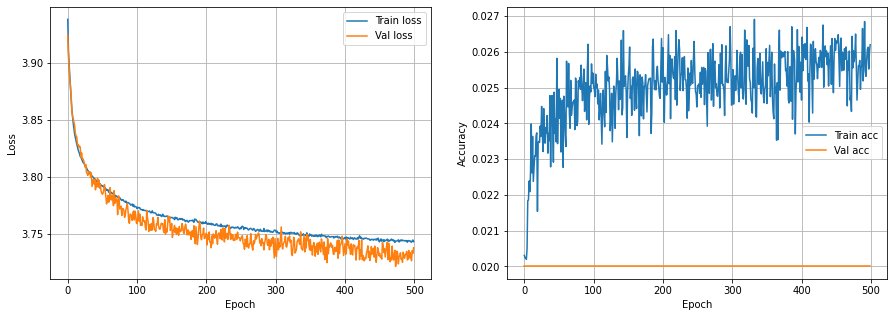

In [35]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model.train_loss,label="Train loss")
ax[0].plot(model.val_loss,label="Val loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(model.train_acc,label="Train acc")
ax[1].plot(model.val_acc,label="Val acc")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()

In [28]:
def topk_Acc(k, RealLabel, PreLabelProb):
    """
    k: top k
    RealLabel: shape -> (num, 1)
    PreLabelProb: shape -> (num, class_num)
    """
    max_k_preds = PreLabelProb.argsort(axis=1)[:, -k:][:, ::-1] #得到top-k label
    match_array = np.logical_or.reduce(max_k_preds==RealLabel, axis=1) #得到匹配結果
    topk_acc_score = match_array.sum() / match_array.shape[0]
    
    return round(topk_acc_score, 4)

In [29]:
prelabel_val, prelabelProb_val = model.predict(val_images)
prelabel_test, prelabelProb_test = model.predict(test_images)

In [30]:
prelabelProb_test.shape

(450, 50)

In [36]:
### validation
val_real = val_labels.reshape(450,1)
prelabel_val, prelabelProb_val = model.predict(val_images)

### test
test_real = test_labels.reshape(450,1)
prelabel_test, prelabelProb_test = model.predict(test_images)


top1_Acc_val = topk_Acc(1,val_real,prelabelProb_val)
top5_Acc_val = topk_Acc(5, val_real, prelabelProb_val)

top1_Acc_test = topk_Acc(1, test_real, prelabelProb_test)
top5_Acc_test = topk_Acc(5, test_real, prelabelProb_test)

print("Top 1 Validation Accuracy: ", top1_Acc_val)
print("Top 5 Validation Accuracy: ", top5_Acc_val)
print("Top 1 Test Accuracy: ", top1_Acc_test)
print("Top 5 Test Accuracy: ", top5_Acc_test)

Top 1 Validation Accuracy:  0.0689
Top 5 Validation Accuracy:  0.2756
Top 1 Test Accuracy:  0.0689
Top 5 Test Accuracy:  0.2133


/home/re6094010/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp
